In [1]:
library(Seurat)
# library(SeuratDisk)
library(tidyverse)
library(patchwork)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.4; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
escAS.data1 <- read.csv("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/result/RNA_Res_1018/counts.gene.genome1.format.tsv",sep = "\t")
escAS.data2 <- read.csv("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/result/RNA_Res_1018/counts.gene.genome2.format.tsv",sep = "\t") 

In [3]:
Xgenes_file <- read.table("/share/Data/hxie/project/202209/esc_xwliu/esc0323/RNA_analysis/Xgenes.txt")
dim(Xgenes_file)
# Xgenes_file <- read.table("Xgenes.txt") %>% rename(gene = V1)
Xgenes.data1 <- intersect(Xgenes_file$V1,rownames(escAS.data1))
Xgenes.data2 <- intersect(Xgenes_file$V1,rownames(escAS.data2))
escAS.data1 <- escAS.data1[rownames(escAS.data1) %in% Xgenes.data1,]
escAS.data2 <- escAS.data2[rownames(escAS.data2) %in% Xgenes.data2,]

[1] 2616    1

In [4]:
escAS.data1 <- escAS.data1[rownames(escAS.data1) %in% Xgenes.data1,]
escAS.data2 <- escAS.data2[rownames(escAS.data2) %in% Xgenes.data2,]

In [5]:
escAS.data1 <- escAS.data1 %>% rownames_to_column("gene") %>% mutate(gene=paste0("B6_",gene)) %>% column_to_rownames("gene")
escAS.data2 <- escAS.data2 %>% rownames_to_column("gene") %>% mutate(gene=paste0("Cast_",gene)) %>% column_to_rownames("gene")

In [6]:
esc.AS.data <- rbind(escAS.data1,escAS.data2)

In [7]:
esc <- readRDS("./RDS/esc_withoutM_1029.rds")

In [8]:
metadata <- esc@meta.data

In [9]:
esc.AS <- CreateSeuratObject(counts = esc.AS.data, min.cells = 1, min.features = 1)
esc.AS@meta.data <- esc.AS@meta.data %>% mutate(cellname = rownames(esc.AS@meta.data))
esc.AS <- subset(esc.AS, subset = cellname %in% rownames(metadata))

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [10]:
esc.AS@meta.data <- esc.AS@meta.data %>% left_join(metadata %>% select(cellname,sample2,sample3,cellcycle_threshold)) %>% column_to_rownames("cellname")

Joining with `by = join_by(cellname)`


In [11]:
esc.AS@meta.data <- esc.AS@meta.data %>% mutate(cellname = rownames(.), day = str_extract(cellname,"d[0-9]+"))

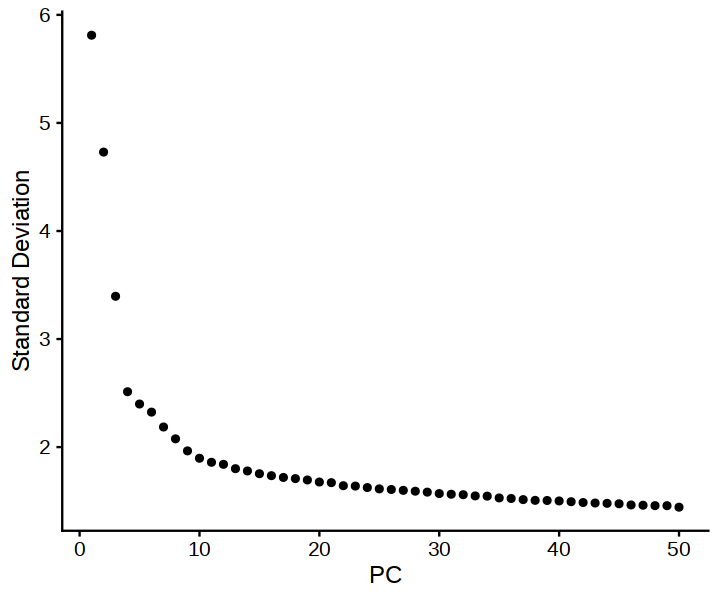

In [12]:
esc.AS <- SCTransform(esc.AS, vst.flavor = "v2", verbose = FALSE)
esc.AS <- RunPCA(esc.AS, verbose = FALSE)
options(repr.plot.width = 6,repr.plot.height = 5)
ElbowPlot(object = esc.AS, ndims = 50)

In [13]:
esc.AS

An object of class Seurat 
2890 features across 1029 samples within 2 assays 
Active assay: SCT (1104 features, 1104 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

In [14]:
library(harmony)
set.seed(42)

Loading required package: Rcpp



In [15]:
esc.AS <- esc.AS %>% RunHarmony("sample3", assay.use="SCT")

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony converged after 9 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.SCT.harmony; see ?make.names for more details on syntax validity”


In [18]:
esc.AS <- RunUMAP(esc.AS, dims = 1:25,n.neighbors=30, verbose = FALSE, reduction = "harmony", min.dist = 0.3)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


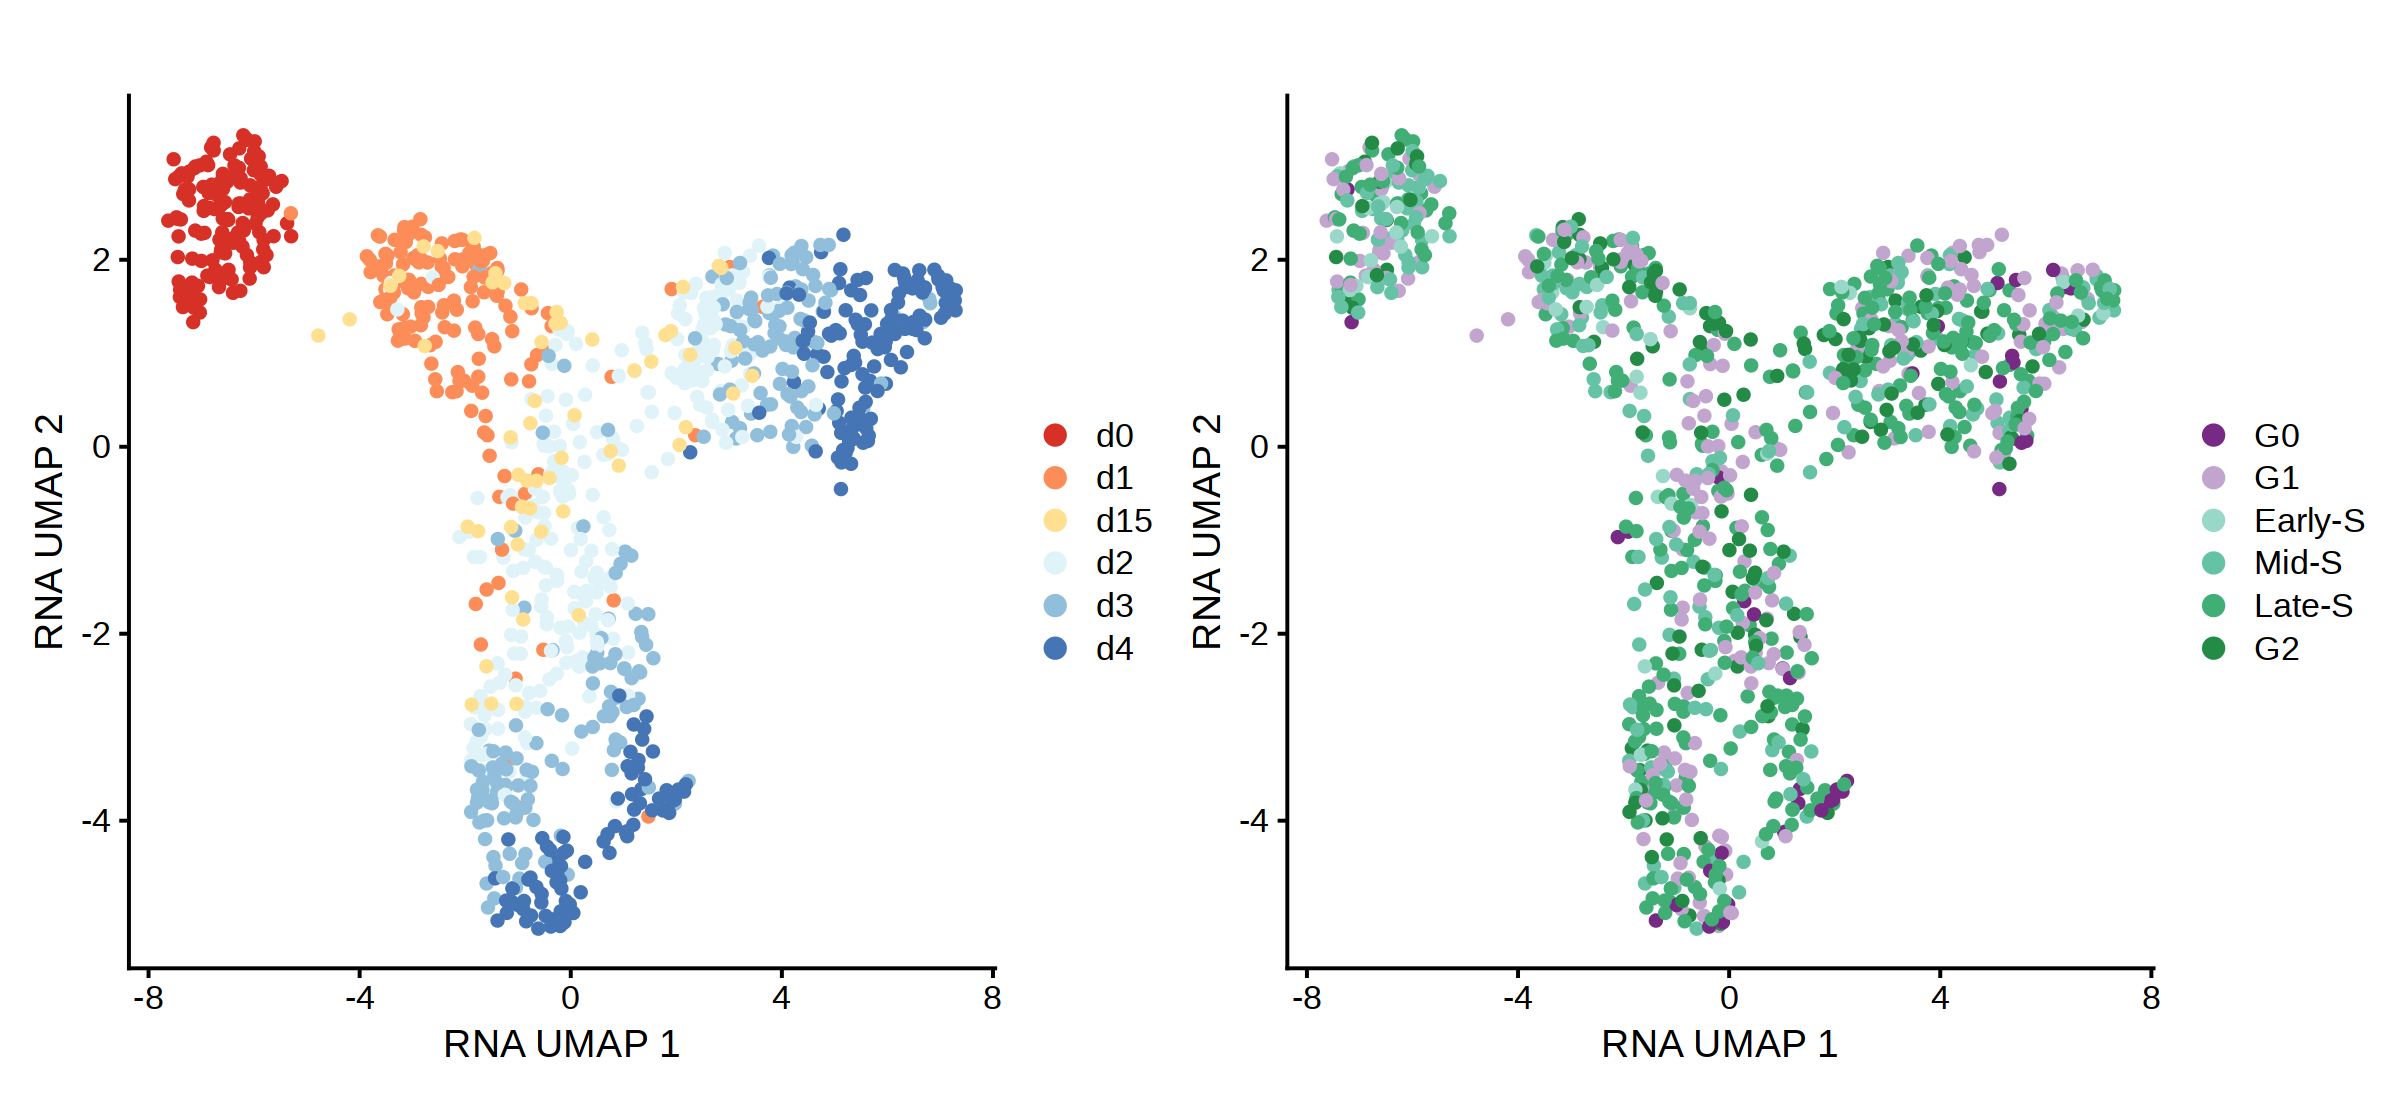

In [19]:
colors = c('#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4')
p1 <- DimPlot(esc.AS, reduction = "umap", group.by = 'day', label = FALSE, pt.size = 1.5, repel = T,cols=alpha(colors,1))  + xlab("RNA UMAP 1") + ylab("RNA UMAP 2") + labs(title = "")
cellcyclecolors = c("G0"="#762a83","G1"="#c2a5cf","Early-S"="#99d8c9","Mid-S"="#66c2a4","Late-S"="#41ae76","G2"="#238b45","M"="#ea6e34","Unknown"="gray")
p2 <- DimPlot(esc.AS, reduction = "umap", group.by = 'cellcycle_threshold', label = F, pt.size = 1.5, repel = T,cols=alpha(cellcyclecolors,1))  + xlab("RNA UMAP 1") + ylab("RNA UMAP 2") + labs(title = "")
options(repr.plot.width = 12,repr.plot.height=5.5, repr.plot.res = 200)
p1 | p2

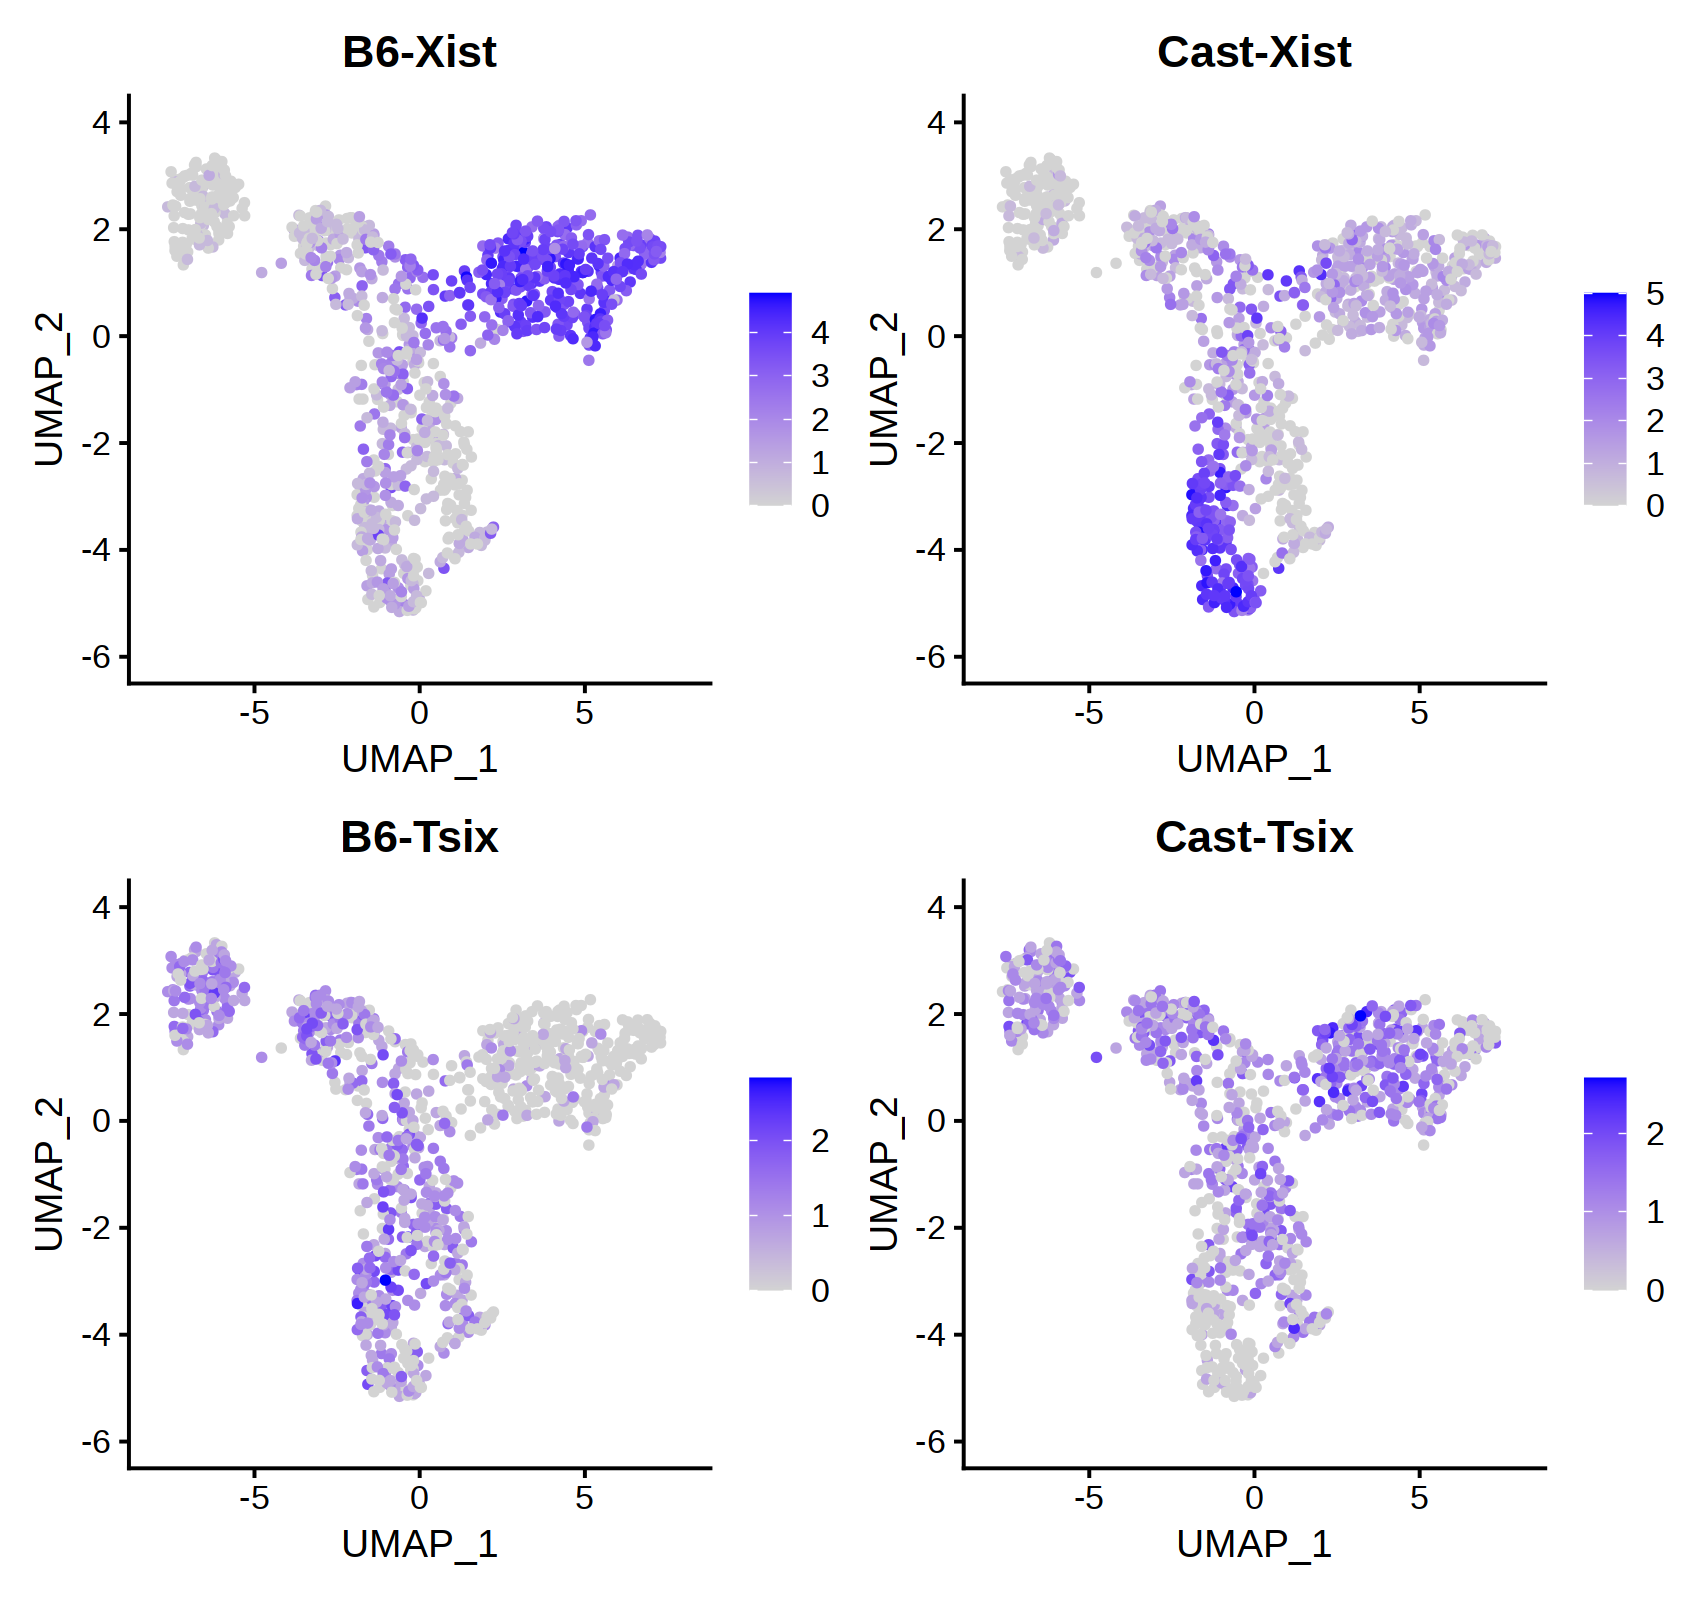

In [20]:
options(repr.plot.width = 8.5,repr.plot.height = 8)
FeaturePlot(esc.AS, features = c("B6-Xist","Cast-Xist","B6-Tsix","Cast-Tsix"), reduction = "umap", pt.size = 1)

In [21]:
p1 <- FeaturePlot(esc.AS, features = c("B6-Xist"), reduction = "umap", pt.size = 1) + xlab("RNA UMAP 1") + ylab("RNA UMAP 2")
p2 <- FeaturePlot(esc.AS, features = c("Cast-Xist"), reduction = "umap", pt.size = 1) + xlab("RNA UMAP 1") + ylab("RNA UMAP 2")
p3 <- FeaturePlot(esc.AS, features = c("B6-Tsix"), reduction = "umap", pt.size = 1) + xlab("RNA UMAP 1") + ylab("RNA UMAP 2")
p4 <- FeaturePlot(esc.AS, features = c("Cast-Tsix"), reduction = "umap", pt.size = 1) + xlab("RNA UMAP 1") + ylab("RNA UMAP 2")

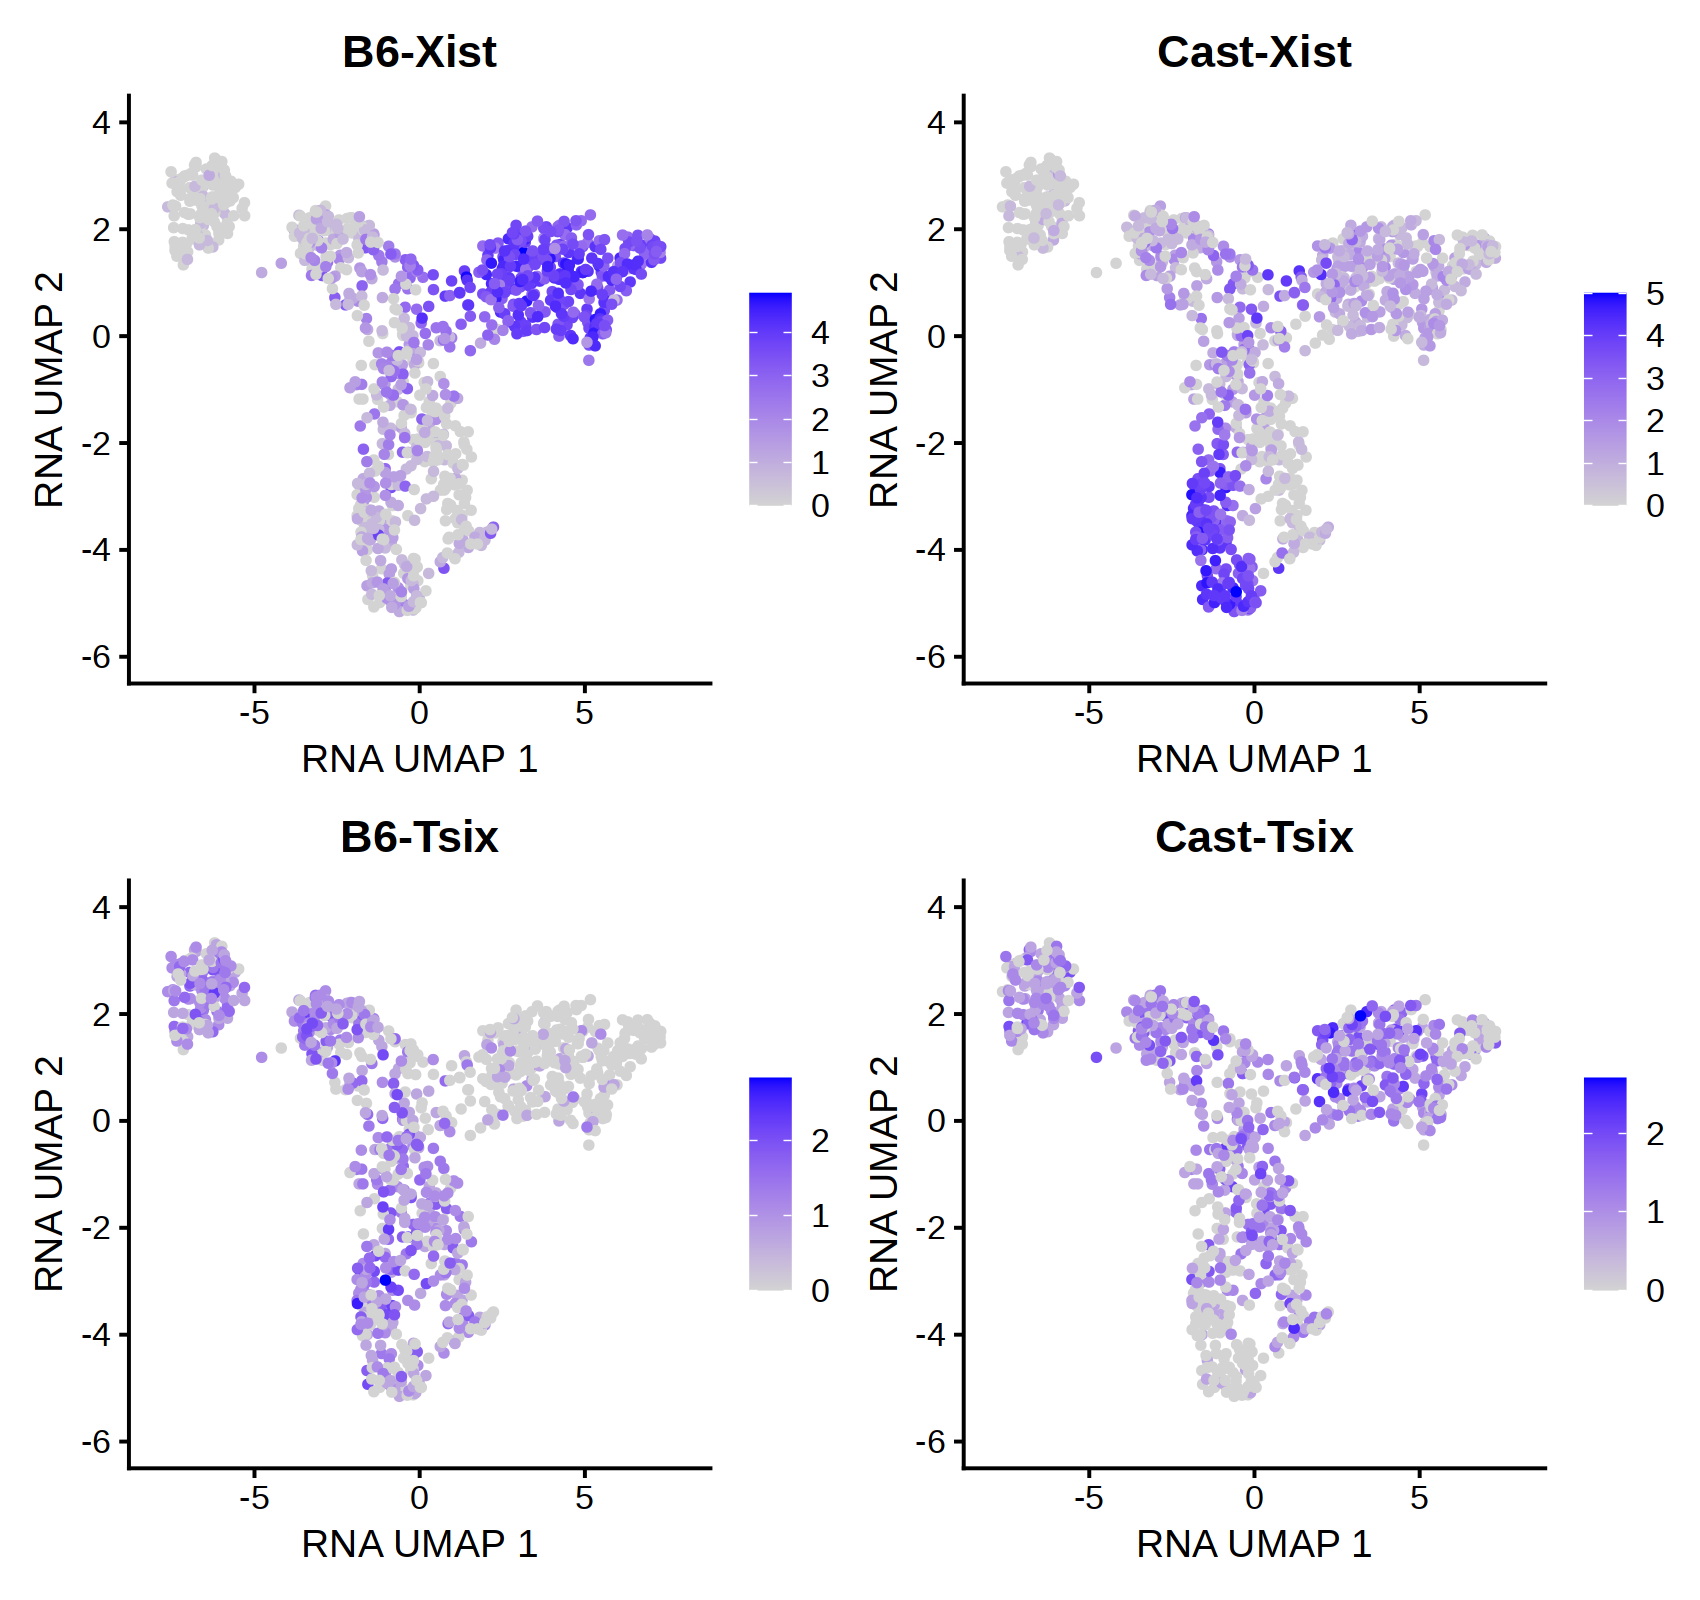

In [22]:
options(repr.plot.width=8.5, repr.plot.height=8)
combined_plot <- (p1 + p2 + p3 + p4) + plot_layout(ncol = 2)
combined_plot

In [23]:
esc.AS <- FindNeighbors(esc.AS, reduction = "harmony",dims = 1:25) %>% FindClusters(resolution = 1.5, verbose = FALSE)

Computing nearest neighbor graph

Computing SNN



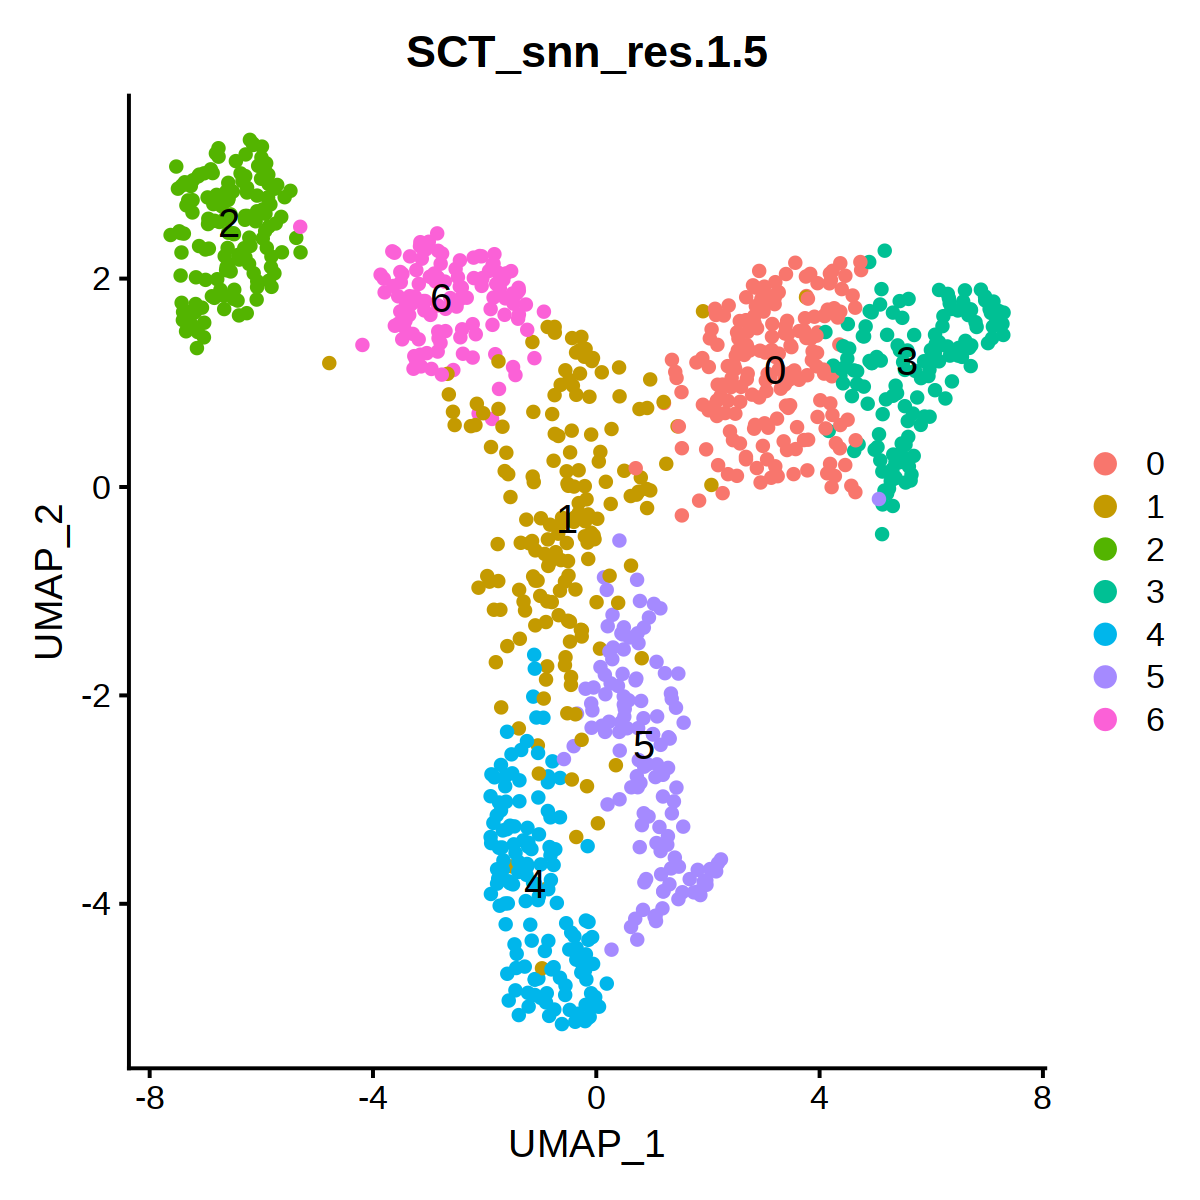

In [24]:
options(repr.plot.width = 6,repr.plot.height=6, repr.plot.res = 200)
DimPlot(esc.AS, reduction = "umap", group.by = 'SCT_snn_res.1.5', label = T, pt.size = 1.5, label.size = 5,repel = F)

In [25]:
esc.AS@meta.data$plot_cluster <- ifelse(esc.AS@meta.data$SCT_snn_res.1.5==2,0,
                            ifelse(esc.AS@meta.data$SCT_snn_res.1.5==6,1,
                            ifelse(esc.AS@meta.data$SCT_snn_res.1.5==1,2,
                            ifelse(esc.AS@meta.data$SCT_snn_res.1.5==4,3,
                            ifelse(esc.AS@meta.data$SCT_snn_res.1.5==0,4,
                            ifelse(esc.AS@meta.data$SCT_snn_res.1.5==3,5,6))))))

In [26]:
colors = c('#d73027','#fc8d59','#fee090','#ffffbf','#e0f3f8','#91bfdb','#bababa')

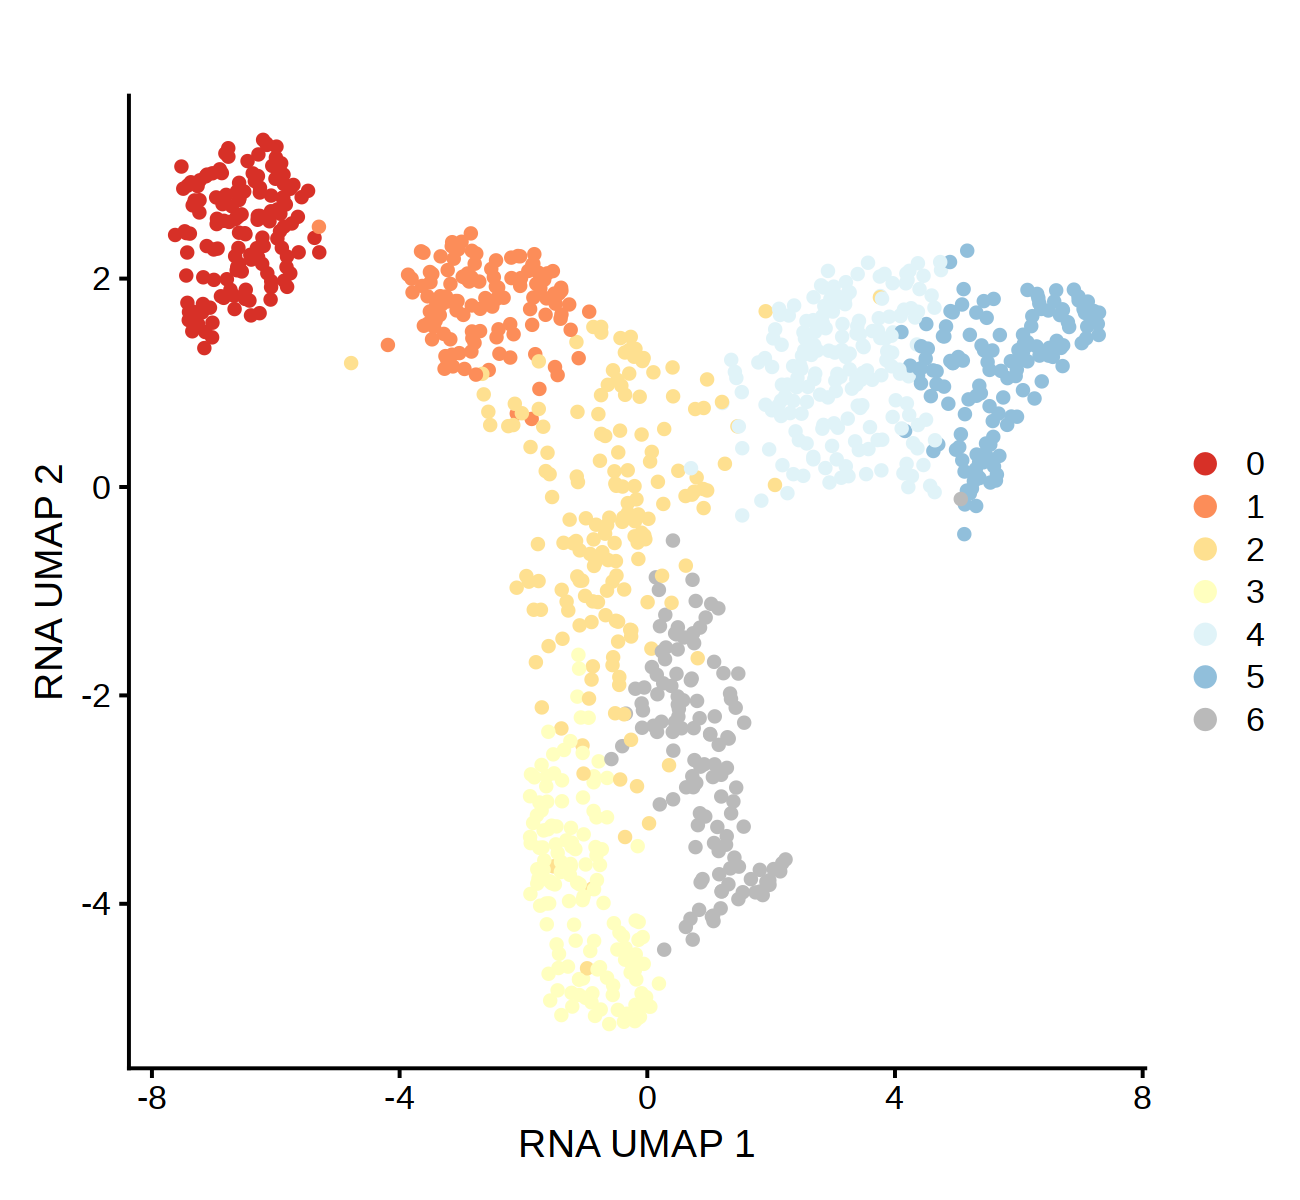

In [27]:
options(repr.plot.width = 6.5,repr.plot.height=6, repr.plot.res = 200)
DimPlot(esc.AS, reduction = "umap", group.by = 'plot_cluster', label = F, pt.size = 1.5, label.size = 0,repel = T,cols=alpha(colors,1)) + xlab("RNA UMAP 1") + ylab("RNA UMAP 2") + labs(title = "")

# Slingshot

In [28]:
library(slingshot)

Loading required package: princurve



In [29]:
dimred <- esc.AS@reductions$pca@cell.embeddings
clustering <- esc.AS$SCT_snn_res.1.5

In [30]:
lineages <- getLineages(data = dimred, clusterLabels = clustering, start.clus = '2', end.clus = c("3","4","5"), reducedDim = "pca")
lineages

Using full covariance matrix



class: SlingshotDataSet 

 Samples Dimensions
    1029         50

lineages: 3 
Lineage1: 2  6  1  0  3  
Lineage2: 2  6  1  4  
Lineage3: 2  6  1  5  

curves: 0 

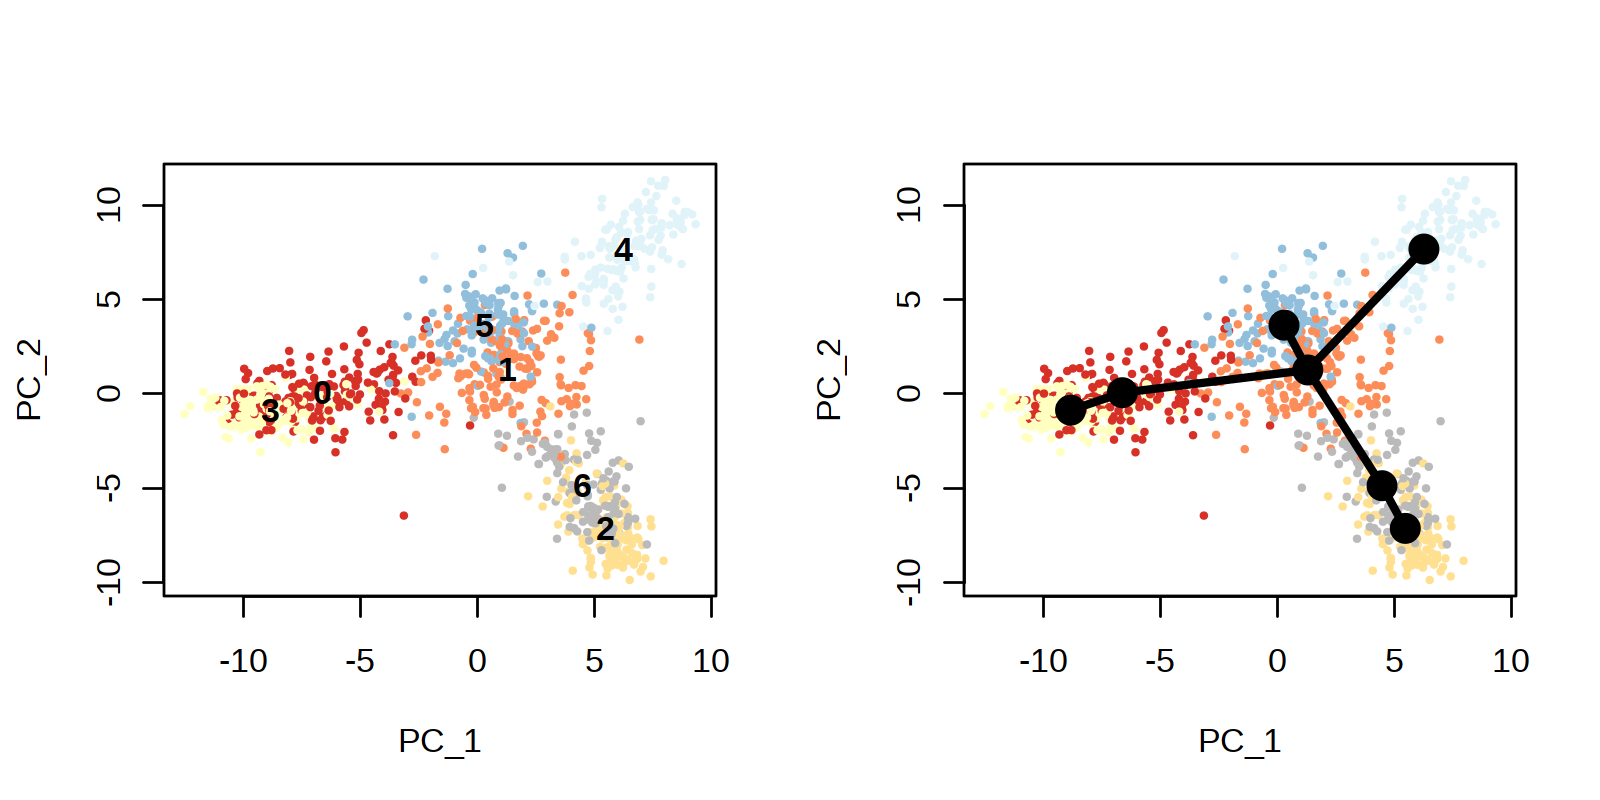

In [31]:
# Plot the lineages
options(repr.plot.width = 8,repr.plot.height = 4)
par(mfrow = c(1, 2))
plot(dimred[, 1:2], col = colors[clustering], cex = 0.5, pch = 16)
for (i in levels(clustering)) {
    text(mean(dimred[clustering == i, 1]), mean(dimred[clustering == i, 2]), labels = i, font = 2)
}
plot(dimred[, 1:2], col = colors[clustering], cex = 0.5, pch = 16)
lines(lineages, lwd = 3, col = "black")

In [32]:
curves <- getCurves(lineages)
curves

class: SlingshotDataSet 

 Samples Dimensions
    1029         50

lineages: 3 
Lineage1: 2  6  1  0  3  
Lineage2: 2  6  1  4  
Lineage3: 2  6  1  5  

curves: 3 
Curve1: Length: 44.394	Samples: 753.02
Curve2: Length: 43.786	Samples: 582.71
Curve3: Length: 48.577	Samples: 570.95

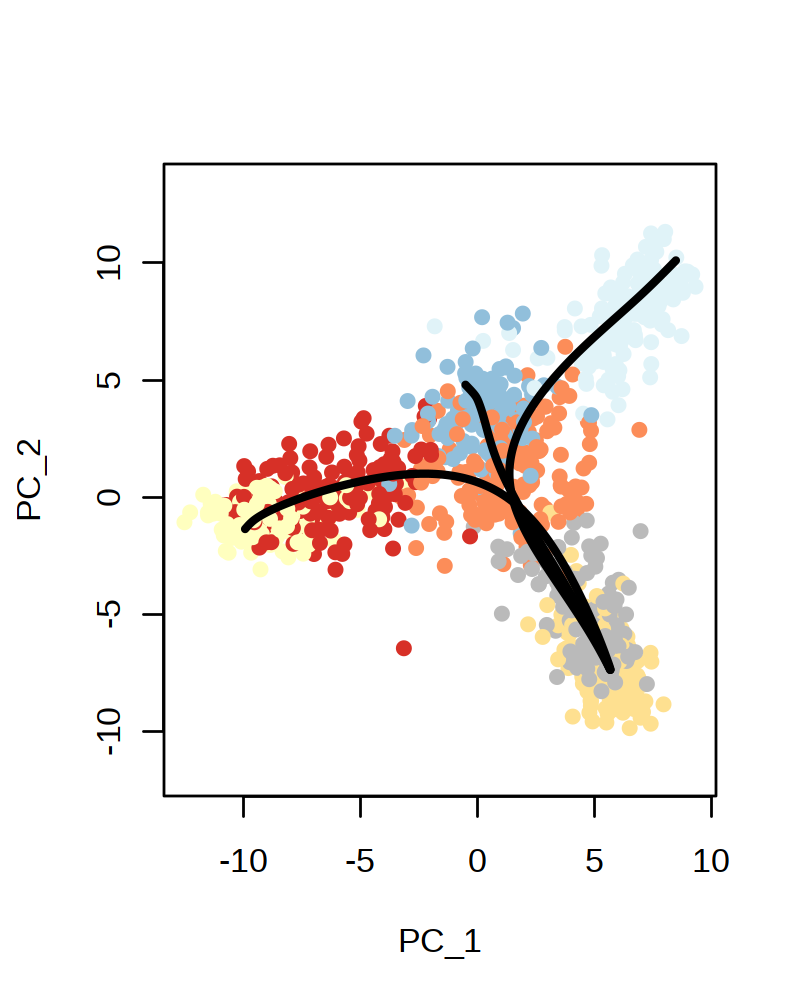

In [33]:
options(repr.plot.width = 4,repr.plot.height = 5)
plot(dimred, col = colors[clustering], asp = 1, pch = 16)
lines(curves, lwd = 3, col = "black")

In [34]:
df <- slingPseudotime(curves)
df <- data.frame(df) %>% rownames_to_column("cellname")
df

cellname,curve1,curve2,curve3
<chr>,<dbl>,<dbl>,<dbl>
d0A1,5.7593640,5.7471038,5.7462708
d0A10,5.8303571,5.8294635,5.8292574
d0A11,8.0694741,8.0882545,8.0866904
d0A12,3.4567281,3.4604648,3.4590320
d0A13,8.2607059,8.2596973,8.2725939
d0A14,3.5654805,3.5635088,3.5673105
d0A15,1.0465420,1.0477264,1.0473455
d0A16,4.9432520,4.9440218,4.9445534
d0A17,6.5395765,6.5354304,6.5337194


In [35]:
esc.AS@meta.data <- esc.AS@meta.data %>% left_join(df %>% select(cellname,curve1,curve2,curve3), by = c("cellname")) %>% 
    column_to_rownames("cellname") %>% mutate(cellname = rownames(.))

In [36]:
library(RColorBrewer)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


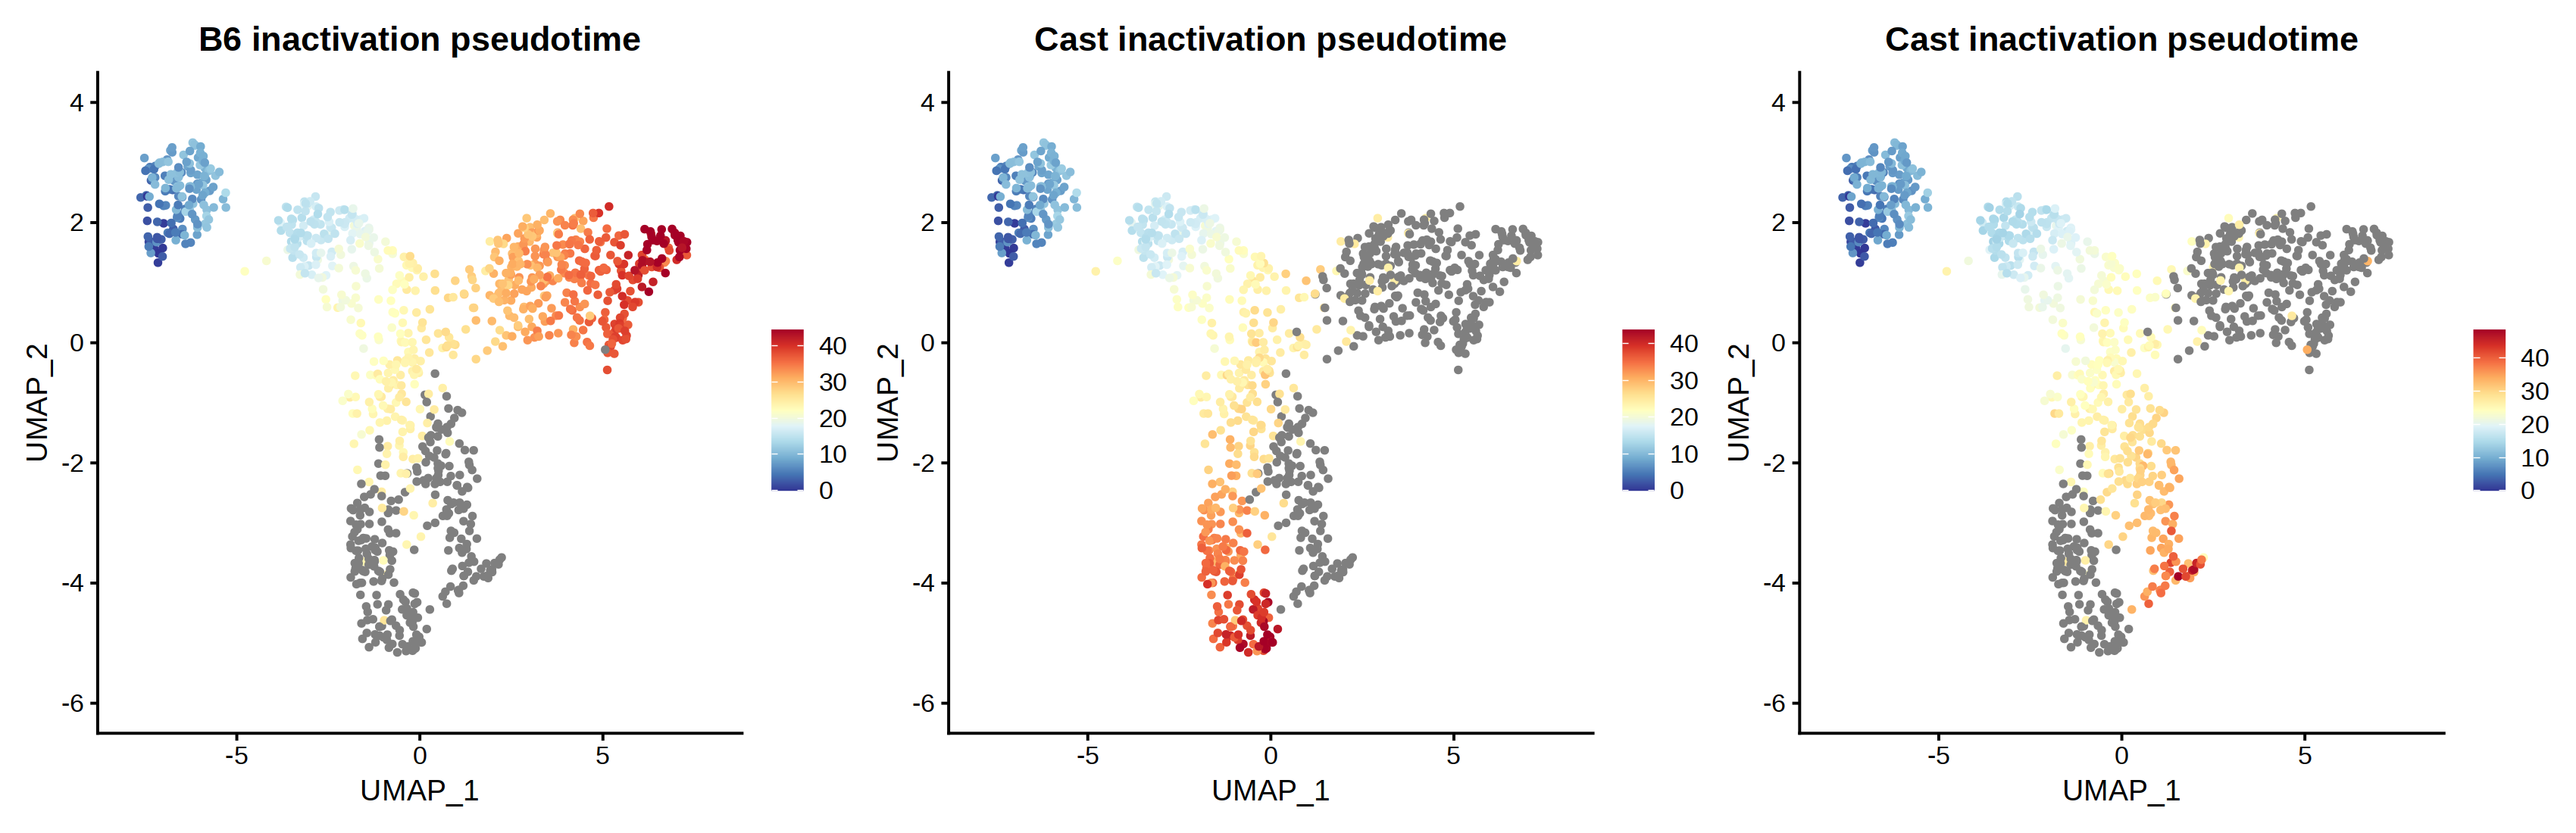

In [37]:
options(repr.plot.width = 17,repr.plot.height = 5.5)
p1 <- FeaturePlot(esc.AS, "curve1")+ scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdYlBu"))) + ggtitle("B6 inactivation pseudotime")
p2 <- FeaturePlot(esc.AS, "curve2")+ scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdYlBu"))) + ggtitle("Cast inactivation pseudotime")
p3 <- FeaturePlot(esc.AS, "curve3")+ scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdYlBu"))) + ggtitle("Cast inactivation pseudotime")
p1 | p2 | p3

In [42]:
esc.AS@meta.data <- esc.AS@meta.data %>% mutate(curve_mean = rowMeans(select(., curve1, curve2, curve3), na.rm = TRUE))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


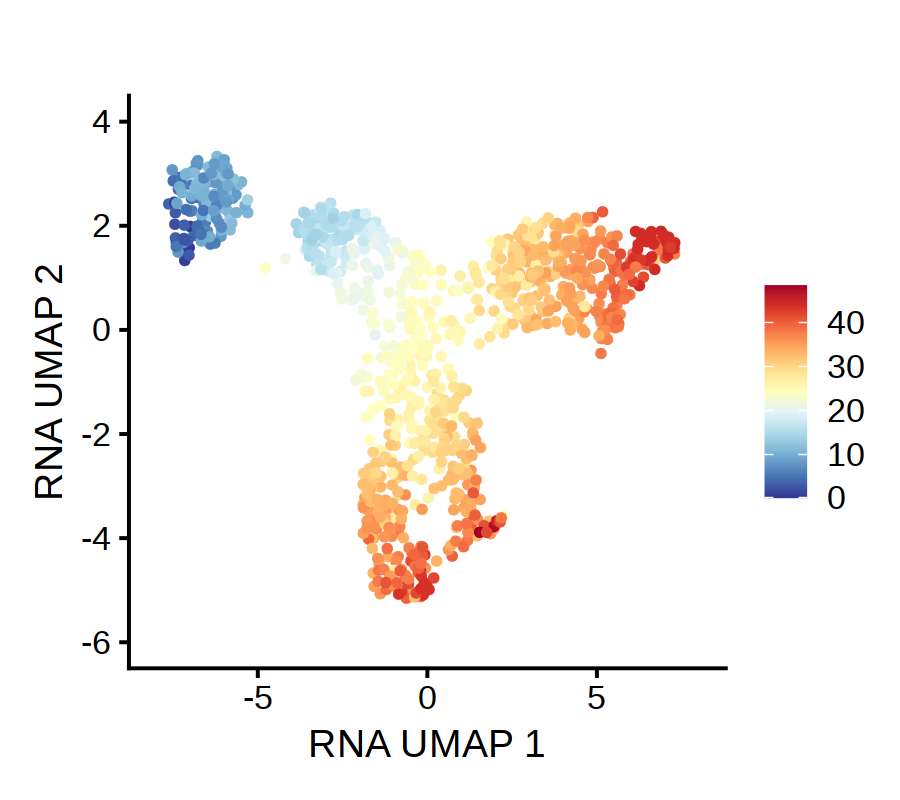

In [48]:
options(repr.plot.width = 4.5,repr.plot.height = 4)
FeaturePlot(esc.AS, "curve_mean")+ scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdYlBu"))) + ggtitle("") + xlab("RNA UMAP 1") + ylab("RNA UMAP 2")


In [49]:
esc.AS

An object of class Seurat 
2890 features across 1029 samples within 2 assays 
Active assay: SCT (1104 features, 1104 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, harmony, umap

In [50]:
saveRDS(esc.AS, "./RDS/esc_AS_remain_neg_1029.rds")

In [8]:
esc.AS <- readRDS("./RDS/esc_AS_remain_neg_1029.rds")

In [9]:
metadata <- esc.AS@meta.data

In [13]:
metadata %>% write_csv("./s1014_metadata_X_noM_Xistneg_remain.csv", col_names = TRUE)

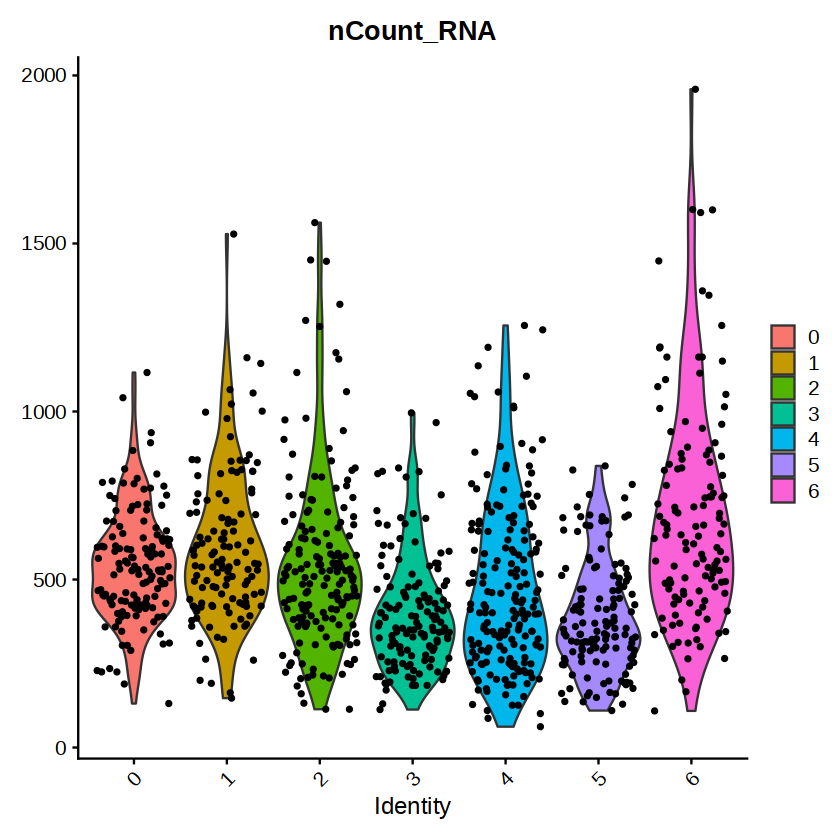

In [13]:
VlnPlot(esc.AS, "nCount_RNA", group.by = "plot_cluster")

In [29]:
allele_exp <- esc.AS[["RNA"]]@data %>% as.data.frame %>% rownames_to_column("gene") %>% mutate(allele = str_extract(gene,"^[^-]+")) %>% select(-gene) %>% group_by(allele) %>%
    summarise(across(starts_with("d"), sum, na.rm = TRUE)) %>% column_to_rownames("allele") %>% t() %>% as.data.frame %>% mutate(cellname = rownames(.))

In [33]:
allele_exp <- allele_exp %>% as.data.frame %>% pivot_longer(!cellname, names_to = "allele", values_to = "UMI") %>% left_join(metadata %>% select(cellname, plot_cluster))

Joining with `by = join_by(cellname)`


In [34]:
library(ggpubr)

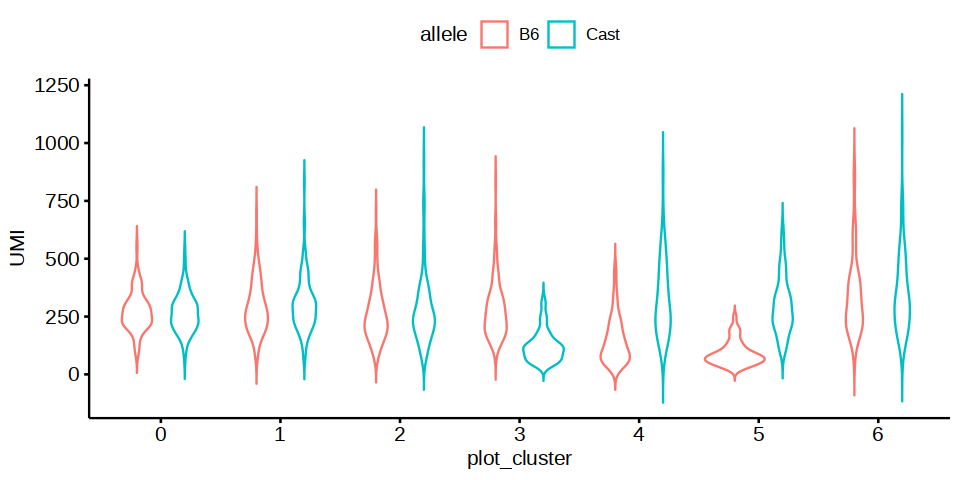

In [42]:
options(repr.plot.width = 8,repr.plot.height = 4)

ggviolin(allele_exp, x = "plot_cluster", y = "UMI", color = "allele")